In [ ]:
# Install library tambahan jika diperlukan
!pip install scikit-learn pandas matplotlib numpy dask

# Import library
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Upload file CSV
from google.colab import files
uploaded = files.upload()

Saving exported_columns_sungaibatanghari2.csv to exported_columns_sungaibatanghari2.csv


In [ ]:
# Membaca data dari file CSV menggunakan Dask
file_name = list(uploaded.keys())[0]
data = dd.read_csv(file_name)

In [ ]:
# Target kolom yang akan digunakan
target_columns = ['pH', 'CHLA', 'TDS', 'EC', 'TSS']
data = data[target_columns]

# Mengetahui jumlah nilai null per kolom
null_counts = data.isna().sum().compute()
print("Jumlah nilai null awal pada setiap kolom:")
print(null_counts)
print("-" * 50)

# Mengisi nilai NaN dengan median (menggunakan Dask)
data = data.fillna(data.median().compute())

# Memastikan tidak ada nilai null setelah pengisian
null_counts_after = data.isna().sum().compute()
print("Jumlah nilai null setelah pengisian:")
print(null_counts_after)
print("-" * 50)

# Mengonversi ke Pandas untuk kompatibilitas dengan Scikit-learn
data = data.compute()

# Standarisasi data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

Jumlah nilai null awal pada setiap kolom:
pH      0
CHLA    0
TDS     0
EC      0
TSS     0
dtype: int64
--------------------------------------------------
Jumlah nilai null setelah pengisian:
pH      0
CHLA    0
TDS     0
EC      0
TSS     0
dtype: int64
--------------------------------------------------


In [ ]:
# Ringkasan statistik deskriptif
print(data.describe())

                  pH           CHLA            TDS             EC  \
count  129762.000000  129762.000000  129762.000000  129762.000000   
mean        8.642229       4.484526    2508.478199    5016.956404   
std         0.060042       3.387743    1160.753441    2321.506888   
min         8.410830      -0.157256     254.159748     508.319511   
25%         8.595326       1.099917    1569.160263    3138.320617   
50%         8.662846       4.433143    2701.907226    5403.814393   
75%         8.691671       7.395269    3433.741287    6867.482422   
max         8.742357      16.376282    6291.997925   12583.996580   

                 TSS  
count  129762.000000  
mean    12928.076292  
std      4161.413136  
min       672.260910  
25%     10816.813657  
50%     14017.406620  
75%     15873.777770  
max     27702.418460  


In [ ]:
import pandas as pd

# Definisikan nilai Si dan V_ideal untuk masing-masing parameter
parameter_info = {
    'pH':       {'Si': 8.5,  'V_ideal': 7},
    'TDS':      {'Si': 1000, 'V_ideal': 0},
    'TSS':      {'Si': 50, 'V_ideal': 0},
    'CHLA':    {'Si': 0.04, 'V_ideal': 0},
    'EC':      {'Si': 300,    'V_ideal': 0},
}

# Hitung K (konstanta proporsionalitas)
K = 1 / sum(1 / parameter_info[param]['Si'] for param in parameter_info)

# Hitung Wi untuk masing-masing parameter
Wi = {param: K / parameter_info[param]['Si'] for param in parameter_info}

# Tampilkan nilai K
print("Nilai K (konstanta proporsionalitas):")
print(K)
print("-" * 50)

# Tampilkan nilai Wi untuk tiap parameter
print("Bobot Wi untuk setiap parameter:")
for param, wi in Wi.items():
    print(f"{param}: {wi}")
print("-" * 50)

# Hitung dan tampilkan total Wi
Wi_total_sum = sum(Wi.values())
print("Total Wi (jumlah seluruh bobot):")
print(Wi_total_sum)
print("-" * 50)

# Fungsi hitung AW-WQI per baris/grid
def hitung_aw_wqi(baris):
    Qi_Wi_total = 0
    Wi_total = 0
    for param in parameter_info:
        Vi = baris[param]
        Si = parameter_info[param]['Si']
        V_ideal = parameter_info[param]['V_ideal']
        Qi = abs((Vi - V_ideal) / (Si - V_ideal)) * 100
        Qi_Wi = Qi * Wi[param]
        Qi_Wi_total += Qi_Wi
        Wi_total += Wi[param]
    return Qi_Wi_total / Wi_total

# Hitung AW-WQI untuk semua grid
data['AW_WQI'] = data.apply(hitung_aw_wqi, axis=1)

# Fungsi klasifikasi
def klasifikasi_aw_wqi(nilai):
    if nilai <= 25:
        return "Sangat Baik"
    elif nilai <= 50:
        return "Baik"
    elif nilai <= 75:
        return "Buruk"
    elif nilai <= 100:
        return "Sangat Buruk"
    else:
        return "Tidak layak untuk dikonsumsi"

# Tambahkan kolom klasifikasi
data['Kualitas_Air'] = data['AW_WQI'].apply(klasifikasi_aw_wqi)

# Tampilkan hasil
print(data[['AW_WQI', 'Kualitas_Air']])


Nilai K (konstanta proporsionalitas):
0.03977411422657675
--------------------------------------------------
Bobot Wi untuk setiap parameter:
pH: 0.004679307556067853
TDS: 3.977411422657675e-05
TSS: 0.000795482284531535
CHLA: 0.9943528556644188
EC: 0.00013258038075525584
--------------------------------------------------
Total Wi (jumlah seluruh bobot):
1.0
--------------------------------------------------
              AW_WQI                  Kualitas_Air
0       23647.677587  Tidak layak untuk dikonsumsi
1       23486.296710  Tidak layak untuk dikonsumsi
2       24144.362750  Tidak layak untuk dikonsumsi
3       24847.833836  Tidak layak untuk dikonsumsi
4       23207.422292  Tidak layak untuk dikonsumsi
...              ...                           ...
129757  15743.460984  Tidak layak untuk dikonsumsi
129758  23008.226768  Tidak layak untuk dikonsumsi
129759  23116.567387  Tidak layak untuk dikonsumsi
129760  22848.028134  Tidak layak untuk dikonsumsi
129761  22493.875942  Tidak 

In [ ]:
# Simpan hasil ke file Excel
data.to_excel('hasil_aw_wqi.xlsx', index=False)

# Hitung jumlah tiap kategori kualitas air
rekap = data['Kualitas_Air'].value_counts().reset_index()
rekap.columns = ['Kategori', 'Jumlah']

# Tampilkan rekap di terminal
print("\nRekap Kategori Kualitas Air:")
print(rekap.to_string(index=False))



Rekap Kategori Kualitas Air:
                    Kategori  Jumlah
Tidak layak untuk dikonsumsi  121226
                 Sangat Baik    4526
                        Baik    2478
                       Buruk     906
                Sangat Buruk     626



Nilai Normalisasi (0-1) Rata-rata Tiap Kategori (Standarisasi Dulu Baru Rata-rata):

                                    pH       TSS       TDS      CHLA        EC
Kualitas_Air                                                                  
Sangat Baik                   0.323853  0.113832  0.034673  0.009606  0.034673
Baik                          0.340990  0.123853  0.039949  0.009785  0.039949
Buruk                         0.372928  0.141491  0.049237  0.010184  0.049237
Sangat Buruk                  0.393343  0.169424  0.058726  0.010893  0.058726
Tidak layak untuk dikonsumsi  0.723246  0.476625  0.396873  0.299827  0.396873


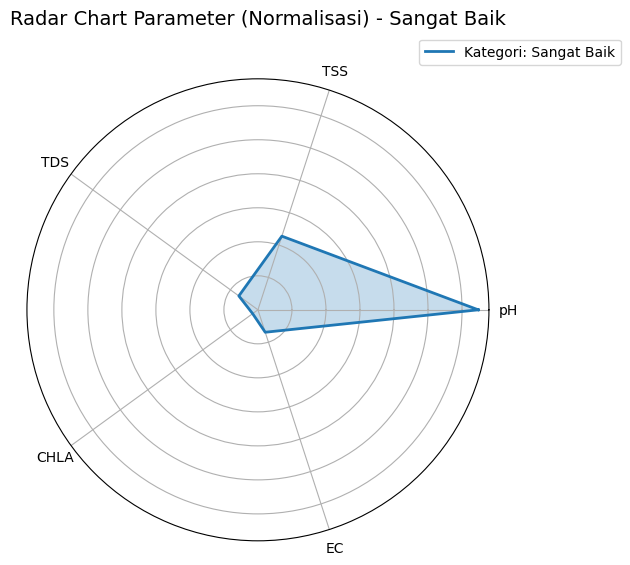

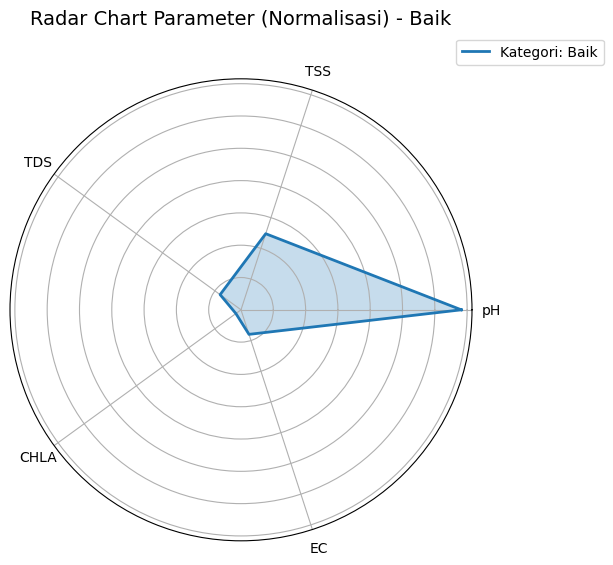

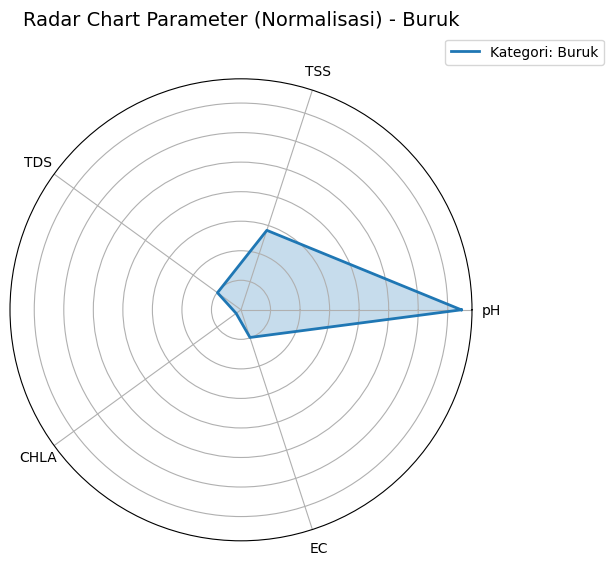

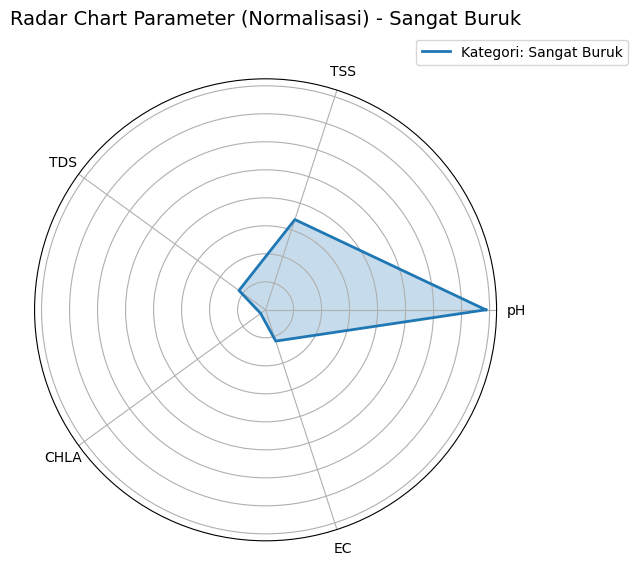

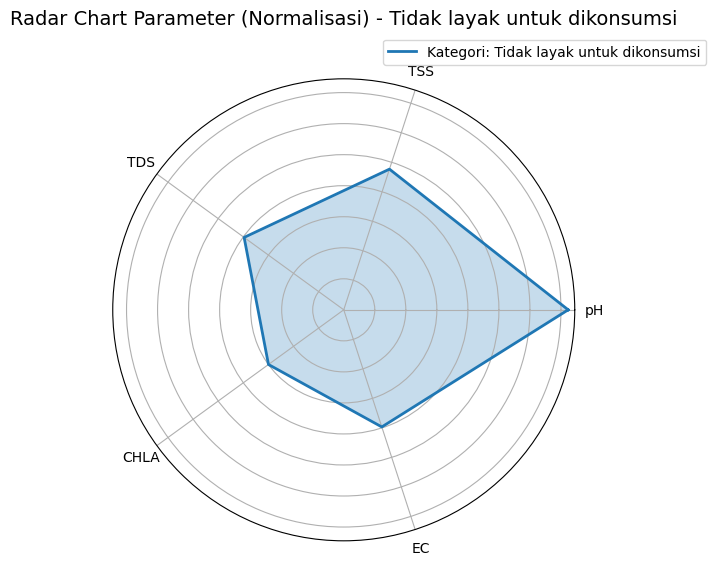

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Target kolom parameter
target_columns = ['pH', 'TSS', 'TDS', 'CHLA', 'EC']

# Normalisasi (min-max scaling per parameter ke skala 0-1) di seluruh data
param_min = data[target_columns].min()
param_max = data[target_columns].max()

data_norm = data.copy()
data_norm[target_columns] = (data_norm[target_columns] - param_min) / (param_max - param_min)

# Hitung rata-rata tiap parameter per kategori Kualitas_Air setelah normalisasi
kategori_avg_norm = data_norm.groupby('Kualitas_Air')[target_columns].mean()

# Urutan kategori custom biar konsisten
urutan_kategori = ['Sangat Baik', 'Baik', 'Buruk', 'Sangat Buruk', 'Tidak layak untuk dikonsumsi']
kategori_avg_norm = kategori_avg_norm.reindex(urutan_kategori)

# Tampilkan nilai normalisasi per kategori
print("\nNilai Normalisasi (0-1) Rata-rata Tiap Kategori (Standarisasi Dulu Baru Rata-rata):\n")
print(kategori_avg_norm)

# Radar chart per kategori
labels = target_columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Plot radar chart tiap kategori
for kategori in kategori_avg_norm.index:
    values = kategori_avg_norm.loc[kategori].tolist()
    values += values[:1]

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

    ax.plot(angles, values, linewidth=2, label=f'Kategori: {kategori}')
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels([])  # biar clean
    ax.set_title(f'Radar Chart Parameter (Normalisasi) - {kategori}', size=14, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.show()



Nilai Normalisasi (0-1) Rata-rata Tiap Kategori (Urut Custom):

                                    pH       TSS       TDS      CHLA        EC
Kualitas_Air                                                                  
Sangat Baik                   0.323853  0.113832  0.034673  0.009606  0.034673
Baik                          0.340990  0.123853  0.039949  0.009785  0.039949
Buruk                         0.372928  0.141491  0.049237  0.010184  0.049237
Sangat Buruk                  0.393343  0.169424  0.058726  0.010893  0.058726
Tidak layak untuk dikonsumsi       NaN       NaN       NaN       NaN       NaN


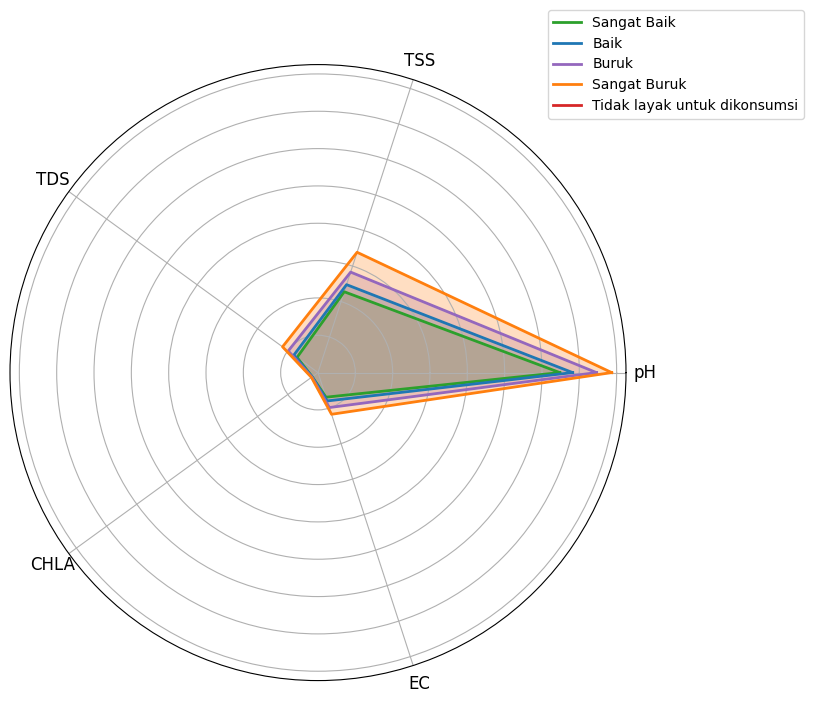

In [ ]:
# Tentukan urutan kategori
urutan_kategori = ['Sangat Baik', 'Baik', 'Buruk', 'Sangat Buruk', 'Tidak layak untuk dikonsumsi']

# Susun ulang index dataframe hasil normalisasi sesuai urutan tersebut
kategori_avg_norm = kategori_avg_norm.reindex(urutan_kategori)

# Tampilkan nilai setelah diurutkan
print("\nNilai Normalisasi (0-1) Rata-rata Tiap Kategori (Urut Custom):\n")
print(kategori_avg_norm)

# Radar chart
labels = target_columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # tutup lingkaran

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))

# Warna untuk tiap kategori
colors = ['#2ca02c', '#1f77b4', '#9467bd', '#ff7f0e', '#d62728']

# Plot tiap kategori
for idx, kategori in enumerate(kategori_avg_norm.index):
    values = kategori_avg_norm.loc[kategori].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=f'{kategori}', color=colors[idx % len(colors)])
    ax.fill(angles, values, alpha=0.25, color=colors[idx % len(colors)])

# Set sumbu & label
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels([])  # biar lebih clean
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


In [ ]:
data['Kualitas_Air'] = data['AW_WQI'].apply(klasifikasi_aw_wqi)

In [ ]:
import pandas as pd

data['Kualitas_Air'] = data['AW_WQI'].apply(klasifikasi_aw_wqi)

# Menyimpan DataFrame ke dalam file CSV
data.to_csv('data_airsungai.csv', index=False)

In [ ]:
from google.colab import files

# Simpan file ke format CSV
data.to_csv('data_airsungai.csv', index=False)

# Menyediakan file untuk di-download
files.download('data_airsungai.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>